In [70]:
import cv2
import glob
import datetime
import matplotlib
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

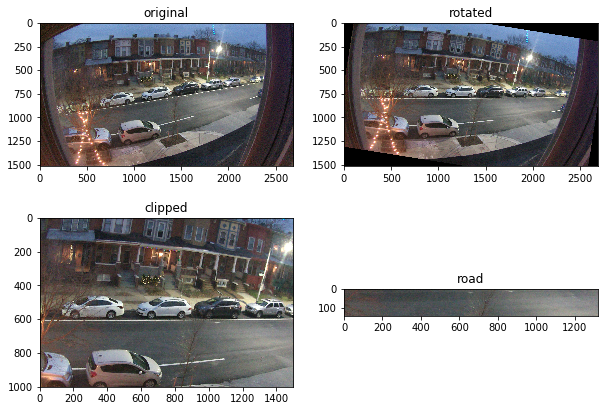

In [71]:
f = plt.figure(figsize=(10,7))

def show_im(n, im, title):
    ax = f.add_subplot(2,2, n)
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(title)

cal_path = "test-images/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip (camera mounted upside down)
show_im(1, cal, "original")

ROTATE_ANGLE = -9
rotated_cal = imutils.rotate(cal, angle=ROTATE_ANGLE) # rotate
show_im(2, rotated_cal, "rotated")

clipped = rotated_cal[200:1200, 500:2000] # clip
show_im(3, clipped, "clipped")

road = clipped[610:750, 180:2000] # clip
show_im(4, road, "road")

Text(0.5, 1.0, 'empty road')

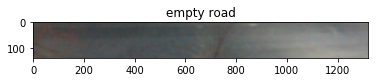

In [72]:
def crop_and_rotate(im):
    rotated = imutils.rotate(im, angle=ROTATE_ANGLE) # rotate
    return rotated[810:950, 680:2000] # clip

def read_road_image(path):
    im = cv2.imread(path)
    if im is None:
        return None
    flipped = cv2.flip(im, -1)
    cropped = crop_and_rotate(flipped)
    return cropped

def blur(im):
    return cv2.GaussianBlur(im, (21, 21), 0)

cal_rotated = crop_and_rotate(cal)
background = blur(cal_rotated)
plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
plt.title('empty road')

In [73]:
def ax_imshow(f, n, im, title, ticks=False):
    ax = f.add_subplot(5,1,n)
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    if not ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    return ax

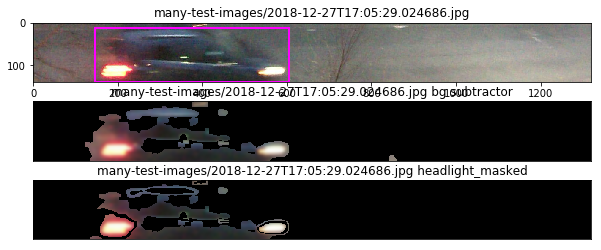

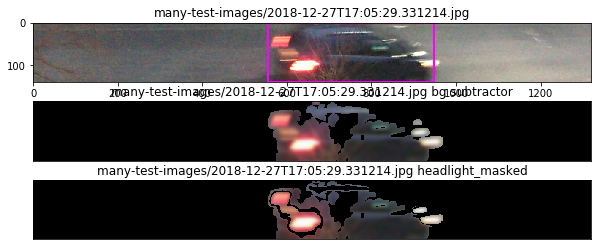

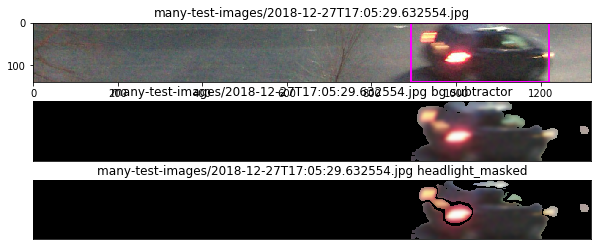

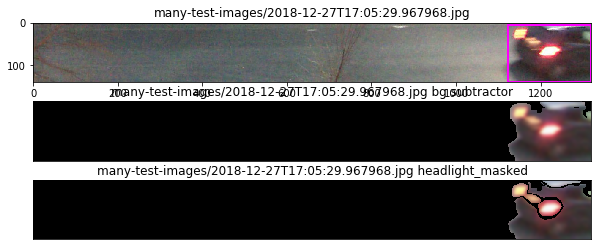

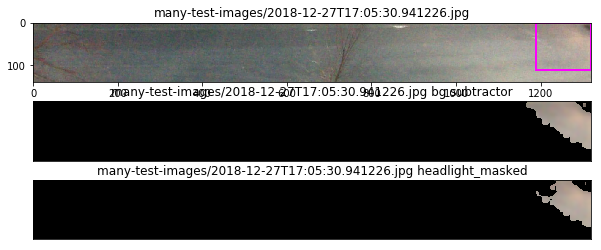

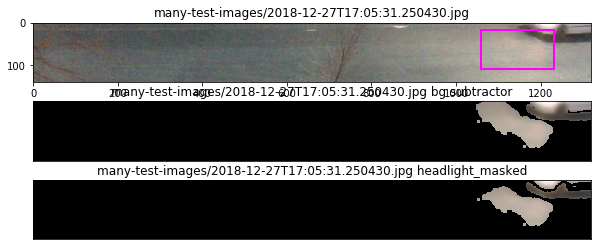

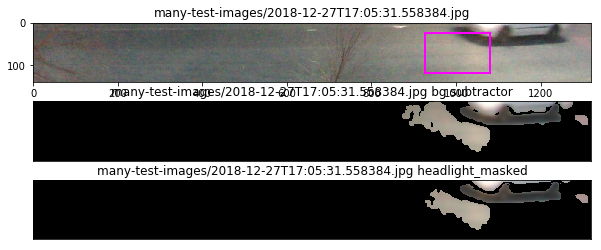

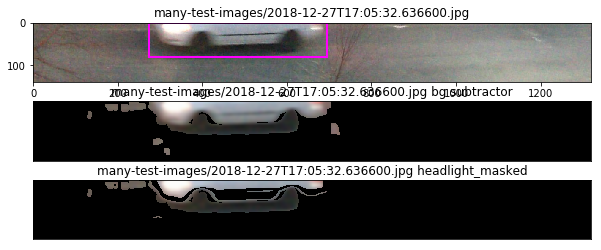

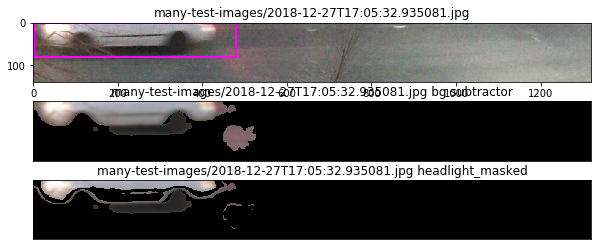

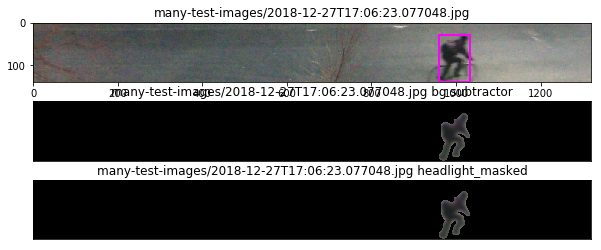

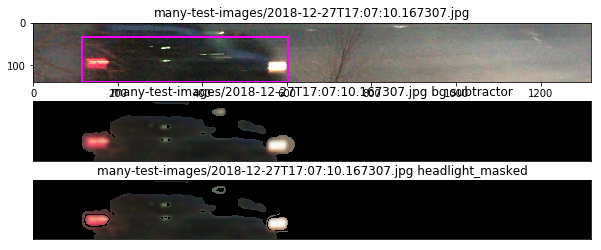

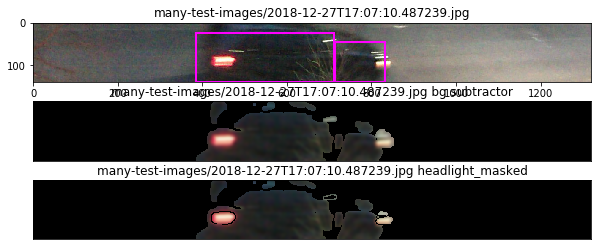

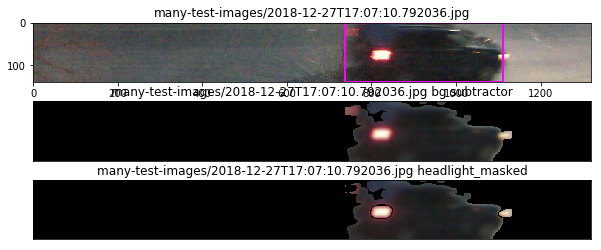

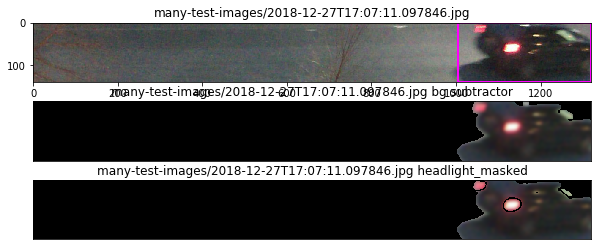

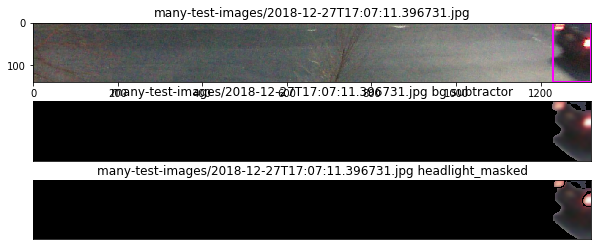

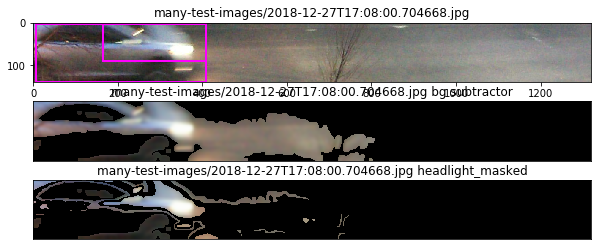

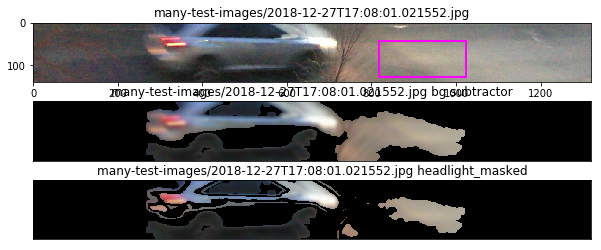

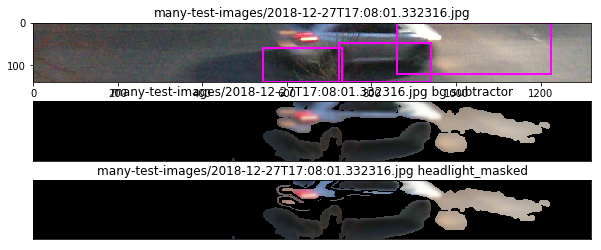

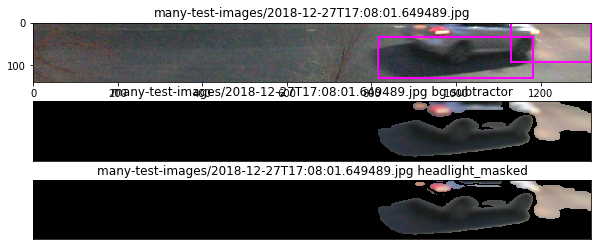

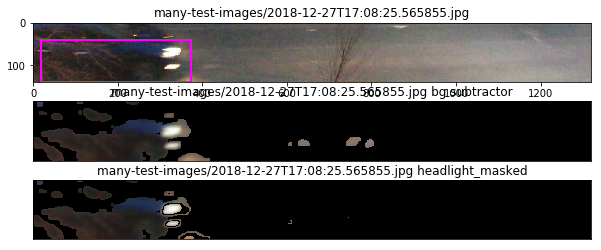

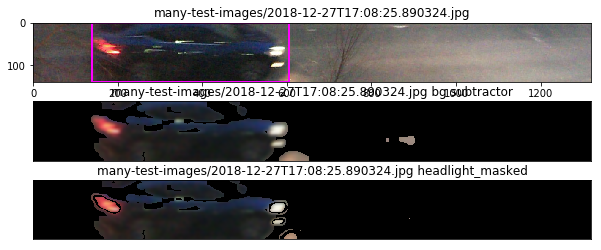

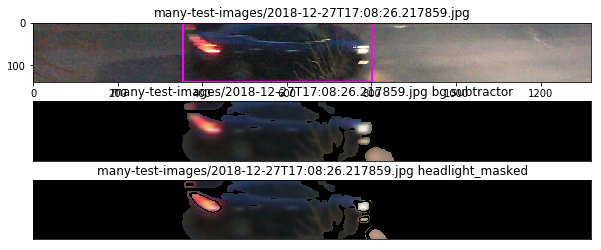

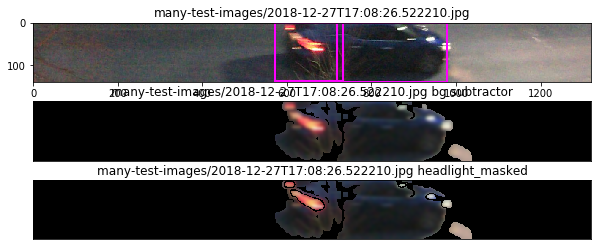

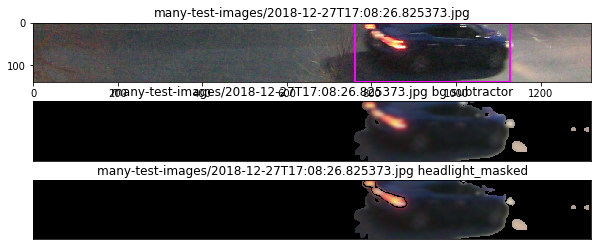

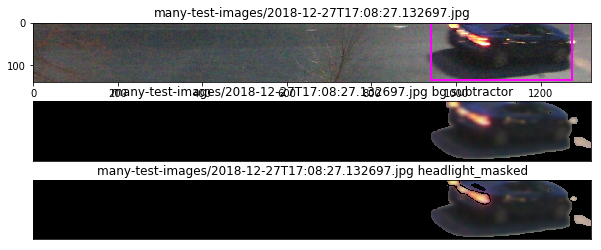

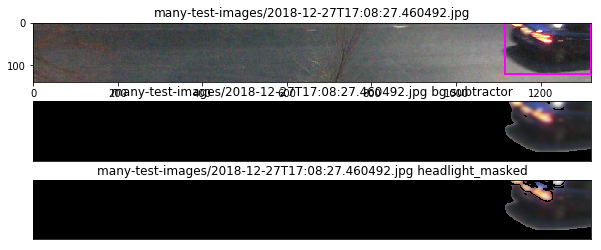

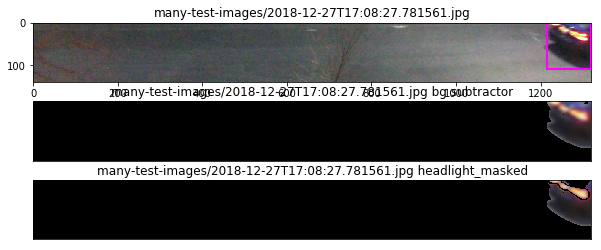

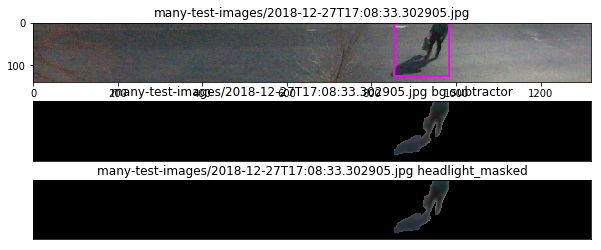

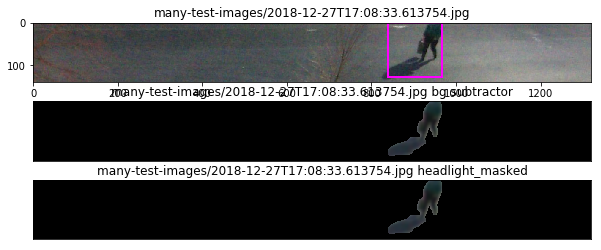

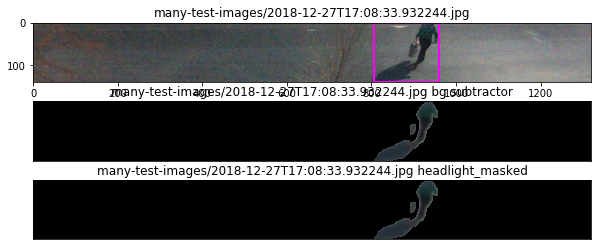

In [78]:
paths = glob.glob("test-images/2018-*.jpg")
paths.sort()

fgbg = cv2.createBackgroundSubtractorMOG2()

processed = []

n_shown=0
for path in paths[:650]:
    color_im = read_road_image(path)
    if color_im is None: # some captured images are empty
        continue
    im = blur(color_im)
    
    # subtract mask background & shadows
    fgmask = fgbg.apply(im)
    shadow_value = 127
    foreground_mask = cv2.threshold(fgmask, shadow_value + 1, 255, cv2.THRESH_BINARY)[1]
    foreground_mask = cv2.dilate(foreground_mask, None, iterations=3)
    bg_subtracted = cv2.bitwise_and(im, im, mask = foreground_mask)
    
    # subtract mask for headlights
    hsv = cv2.cvtColor(bg_subtracted, cv2.COLOR_BGR2HSV)
    v_channel = hsv[:,:,2]
    headlight_mask = cv2.inRange(v_channel, 120, 160)
    not_headlight_mask = cv2.bitwise_not(headlight_mask)
    headlight_masked = cv2.bitwise_and(bg_subtracted, bg_subtracted, mask = not_headlight_mask)
    
    # have to convert to gray before applying find contours
    gray_res = cv2.cvtColor(headlight_masked, cv2.COLOR_BGR2GRAY)
    cnts = cv2.findContours(gray_res, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    contour_rectangles = []
    for c in cnts:
        area = cv2.contourArea(c)
        (x,y,w,h) = cv2.boundingRect(c)
        if area < 4_500: # too small
            continue
        if w > 750: # too wide
            continue
        if h < 80: # too short
            continue
#         print("n_shown={} area={}".format(n_shown, area))
        contour_rectangles.append(cv2.boundingRect(c))
    
    if len(contour_rectangles) == 0:
        continue

    # show figure
    f = plt.figure(figsize=(10,7))
    ax = ax_imshow(f, 1, cv2.cvtColor(color_im, cv2.COLOR_BGR2RGB), "{}".format(path), ticks=True)
    for (x, y, w, h) in contour_rectangles:
        ax.add_patch(matplotlib.patches.Rectangle((x, y), w, h, color='magenta', fill=False, linewidth=2.0))
    ax_imshow(f, 2, cv2.cvtColor(bg_subtracted, cv2.COLOR_BGR2RGB), "{} bg subtractor".format(path))
    ax_imshow(f, 3, cv2.cvtColor(headlight_masked, cv2.COLOR_BGR2RGB), "{} headlight_masked".format(path))
    
    processed.append({'figure': f, 'bg_subtracted': bg_subtracted, 'hsv': hsv})
    
    n_shown +=1
    if n_shown > 50:
        break

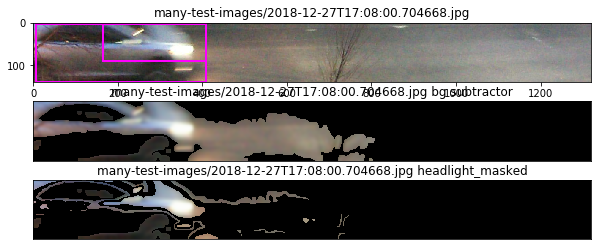

In [88]:
processed[15]['figure']

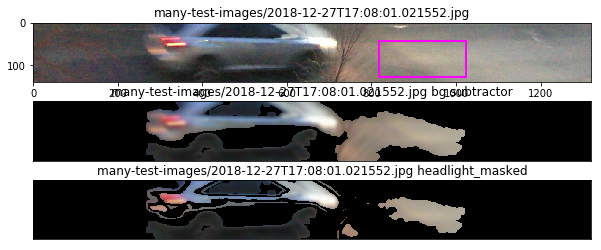

In [87]:
processed[16]['figure']